# Astro M33

This notebook analyzes astronomy spectra data for age characteristics for chemically peculiar / non-chemically peculiar stars.

## Setup

Do the imports and create the spark session instance.

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import matplotlib.patches as patches
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("Astro") \
    .enableHiveSupport() \
    .getOrCreate()

## Ingest

This function copies the astronomy data to a managed table. This will take some time (and disk space), but it only needs to be done once ever for the entire dataset, and it will speed up any future analysis. Any future runs of ingest() will be ignored (silently fail) due to the table already existing.

To re-ingest, one must first run this to delete the data:
```python
spark.sql('drop table astro')
```

In [2]:
# Uncomment to delete the table if necessary
# spark.sql('drop table spectra')

In [3]:
# Uncomment to delete the table if necessary
# spark.sql('drop table absorption')

In [4]:
def split_fixed_width_col(column):
    return split(trim(column), ' +')

def filter_headers(raw_df):
    return raw_df.filter(~col('value').startswith('#'))

def ingest_spectra():
    if "spectra" in [t.name for t in spark.catalog.listTables("default")]:
        print('Table "spectra" already exists. Ignoring.')
        return
    raw = spark.read.text("../data/spectra/*/*/hmix.*")
    raw_filtered = filter_headers(raw)
    
    cleaned = raw_filtered \
        .select( \
            split(input_file_name(), '/').alias('fn_split'), \
            split_fixed_width_col(col('value')).alias('raw_split') \
        ) \
        .select( \
            element_at(col('fn_split'), -3).alias('dataset'), \
            element_at(col('fn_split'), -2).alias('cp_str'), \
            element_at(col('fn_split'), -1).alias('fn'), \
            col('raw_split')[0].cast('float').alias('wavelength'), \
            col('raw_split')[1].cast('float').alias('flam') \
        ) \
        .select( \
            col('dataset'), \
            when(col('cp_str') == 'cp', 1).otherwise(0).alias('is_cp'), \
            substring(col('fn'), 7, 6).cast('bigint').alias('age_mil'), \
            substring(col('fn'), 14, 4).cast('int').alias('heavy_metal_c'), \
            col('wavelength'), \
            col('flam') \
        )
    cleaned \
        .write \
        .mode('ignore') \
        .partitionBy( \
            'dataset', \
            'heavy_metal_c', \
            'is_cp', \
            'age_mil' \
        ) \
        .bucketBy(8, 'wavelength') \
        .format('orc') \
        .saveAsTable('spectra')
    
def ingest_absorption():
    if "absorption" in [t.name for t in spark.catalog.listTables("default")]:
        print('Table "absorption" already exists. Ignoring.')
        return
    raw = spark.read.text("../data/absorption/index.table")
    raw_filtered = filter_headers(raw)
    cleaned = raw_filtered \
        .select( \
                split_fixed_width_col(col('value')).alias('raw_split') \
        ) \
        .select( \
                col('raw_split')[0].cast('int').alias('id'), \
                col('raw_split')[1].cast('float').alias('index_band_min'), \
                col('raw_split')[2].cast('float').alias('index_band_max'), \
                col('raw_split')[3].cast('float').alias('blue_continuum_min'), \
                col('raw_split')[4].cast('float').alias('blue_continuum_max'), \
                col('raw_split')[5].cast('float').alias('red_continuum_min'), \
                col('raw_split')[6].cast('float').alias('red_continuum_max'), \
                col('raw_split')[7].cast('int').alias('units'), \
                col('raw_split')[8].alias('name'), \
        )
    cleaned \
        .write \
        .mode('ignore') \
        .format('orc') \
        .saveAsTable('absorption')
    

In [5]:
ingest_spectra()

Table "spectra" already exists. Ignoring.


In [6]:
ingest_absorption()

Table "absorption" already exists. Ignoring.


## Let's take a look at the data in the tables...

In [7]:
spark.table('spectra').show()

+----------+--------+--------+-------------+-----+-------+
|wavelength|    flam| dataset|heavy_metal_c|is_cp|age_mil|
+----------+--------+--------+-------------+-----+-------+
|   3000.38|25314.78|m33_0.01|          790|    0|    100|
|   8859.64|2000.581|m33_0.01|          790|    0|    100|
|    3000.5|25166.85|m33_0.01|          790|    0|    100|
|   8859.85|1988.565|m33_0.01|          790|    0|    100|
|   3000.52| 25134.6|m33_0.01|          790|    0|    100|
|    8859.9|1988.374|m33_0.01|          790|    0|    100|
|   3000.58|25026.55|m33_0.01|          790|    0|    100|
|   8859.99|1989.904|m33_0.01|          790|    0|    100|
|   3000.76|24667.97|m33_0.01|          790|    0|    100|
|   8860.12|1994.742|m33_0.01|          790|    0|    100|
|   3000.83|24560.54|m33_0.01|          790|    0|    100|
|   8860.14|1995.604|m33_0.01|          790|    0|    100|
|   3001.01|24524.21|m33_0.01|          790|    0|    100|
|   8860.15|1996.036|m33_0.01|          790|    0|    10

In [8]:
spark.table('absorption').show()

+---+--------------+--------------+------------------+------------------+-----------------+-----------------+-----+-------+
| id|index_band_min|index_band_max|blue_continuum_min|blue_continuum_max|red_continuum_min|red_continuum_max|units|   name|
+---+--------------+--------------+------------------+------------------+-----------------+-----------------+-----+-------+
|  1|      4142.125|      4177.125|          4080.125|          4117.625|         4244.125|         4284.125|    1|   CN_1|
|  2|      4142.125|      4177.125|          4083.875|          4096.375|         4244.125|         4284.125|    1|   CN_2|
|  3|       4222.25|       4234.75|            4211.0|           4219.75|           4241.0|           4251.0|    0| Ca4227|
|  4|      4281.375|      4316.375|          4266.375|          4282.625|         4318.875|         4335.125|    0|  G4300|
|  5|      4369.125|      4420.375|          4359.125|          4370.375|         4442.875|         4455.375|    0| Fe4383|
|  6|   

## We can also execute SQL statements like so...

In [9]:
spark.sql('SELECT * FROM spectra WHERE is_cp=1 AND age_mil=14 LIMIT 10').show()

+----------+--------+--------+-------------+-----+-------+
|wavelength|    flam| dataset|heavy_metal_c|is_cp|age_mil|
+----------+--------+--------+-------------+-----+-------+
|   3000.38|311351.3|m33_0.01|          790|    1|     14|
|   6578.86|16179.39|m33_0.01|          790|    1|     14|
|    3000.5|311013.9|m33_0.01|          790|    1|     14|
|    6579.0|16262.56|m33_0.01|          790|    1|     14|
|   3000.52|310993.6|m33_0.01|          790|    1|     14|
|   6579.04|16280.62|m33_0.01|          790|    1|     14|
|   3000.58|310997.0|m33_0.01|          790|    1|     14|
|    6579.1|16305.47|m33_0.01|          790|    1|     14|
|   3000.76|311354.0|m33_0.01|          790|    1|     14|
|   6579.11|16309.48|m33_0.01|          790|    1|     14|
+----------+--------+--------+-------------+-----+-------+



## We can also sample from the data, and plot it...

In [10]:
def pick_spectrum( \
    data_set='m33_0.01', \
    heavy_metal_c=790, \
    age_mil=11):
    
    table = spark.table('spectra')
    return table.filter( \
        (col('dataset') == data_set) & \
        (col('heavy_metal_c') == heavy_metal_c) & \
        (col('age_mil') == age_mil) \
    )

def sample_and_plot_spectrum( \
    spectrum, \
    num_samples=2000, \
    min_wavelength=3000.0, \
    max_wavelength=10000.0):
    wavelength_increment = (max_wavelength - min_wavelength)/num_samples

    bins = spectrum.select( \
            ( \
                floor( \
                    col('wavelength')/wavelength_increment \
                )*wavelength_increment \
            ).alias('wavelength'), \
            col('is_cp'), \
            col('flam'), \
        ) \
        .filter( \
            (col('wavelength') >= min_wavelength) & \
                (col('wavelength') <= max_wavelength) \
        ) \
        .groupBy( \
            col('wavelength'), \
            col('is_cp') \
        ) \
        .agg(avg(col('flam')).alias('avg_flam'))
    
    transf = bins.alias('b1') \
        .join( \
            bins.alias('b2'), \
            (col('b1.wavelength') == col('b2.wavelength')) & \
                (col('b1.is_cp') == 0) & \
                (col('b2.is_cp') == 1) \
        ) \
        .select( \
            col('b1.wavelength').alias('wavelength'), \
            col('b1.avg_flam').alias('flam_no_cp'), \
            col('b2.avg_flam').alias('flam_cp') \
        ) \
        .orderBy(col('wavelength'))
    
    sampled_pdf = transf.toPandas().set_index('wavelength')
    sampled_pdf.plot.line()

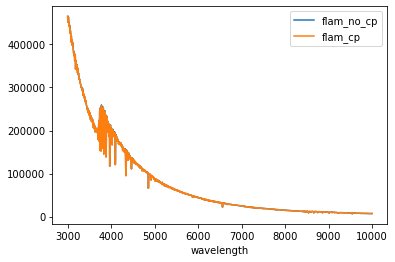

In [11]:
# Let's plot the whole spectrum to see what we're dealing with...
sample_and_plot_spectrum( \
    pick_spectrum( \
        data_set='m33_0.01', \
        heavy_metal_c=790, \
        age_mil=11 \
    ) \
)

## Let's take a look at specific absorption lines...

In [12]:
def get_absorption_line_data(name):
    absorption = spark.table('absorption')
    row = absorption \
        .select( \
            col('index_band_min'), \
            col('index_band_max'), \
            col('blue_continuum_min'), \
            col('blue_continuum_max'), \
            col('red_continuum_min'), \
            col('red_continuum_max') \
        ) \
        .filter(col('name') == name) \
        .first()
    return row.asDict()

def find_f_continuum_no_cp(spectrum, absorption_data):
    row = spectrum \
        .select( \
            col('flam') \
        ) \
        .filter( \
            (col('is_cp') == 0) & \
                (\
                    ((col('wavelength') >= absorption_data['blue_continuum_min']) & \
                        (col('wavelength') <= absorption_data['blue_continuum_max'])) | \
                    ((col('wavelength') >= absorption_data['red_continuum_min']) & \
                        (col('wavelength') <= absorption_data['red_continuum_max'])) \
                ) \
        ) \
        .agg(avg(col('flam')).alias('avg_flam')) \
        .select(col('avg_flam')) \
        .first()
    return row.asDict()['avg_flam']

def find_f_line_no_cp(spectrum, absorption_data):
    row = spectrum \
        .select( \
                col('flam') \
        ) \
        .filter( \
            (col('is_cp') == 0) & \
                (col('wavelength') >= absorption_data['index_band_min']) & \
                (col('wavelength') <= absorption_data['index_band_max']) \
        ) \
        .agg(avg(col('flam')).alias('avg_flam')) \
        .select(col('avg_flam')) \
        .first()
    return row.asDict()['avg_flam']

def calc_equivalent_width(f_cont, f_line, delta_index_band):
    return (f_cont - f_line) / f_cont * delta_index_band

def plot_absorption_line(spectrum, line_name):
    line_data = get_absorption_line_data(line_name)
    
    f_cont = find_f_continuum_no_cp(spectrum, line_data)
    f_line = find_f_line_no_cp(spectrum, line_data)
    
    sample_and_plot_spectrum( \
        spectrum, \
        min_wavelength=line_data['blue_continuum_min'] - 20, \
        max_wavelength=line_data['red_continuum_max'] + 20, \
    )

    ax = plt.gca()
    ax.axhline(y=f_cont, color='grey', linestyle='--', label='f_cont_no_cp')
    ax.axhline(y=f_line, color='black', linestyle='--', label='f_line_no_cp')
    ax.axvspan(line_data['index_band_min'], line_data['index_band_max'], alpha=0.1, color='black')
    ax.axvspan(line_data['blue_continuum_min'], line_data['blue_continuum_max'], alpha=0.1, color='blue')
    ax.axvspan(line_data['red_continuum_min'], line_data['red_continuum_max'], alpha=0.1, color='red')
    ax.legend()
    
    ew = calc_equivalent_width(f_cont, f_line, line_data['index_band_max']-line_data['index_band_min'])
    print('Equivalent width: %s' % (ew))

Equivalent width: 3.7400577708948592


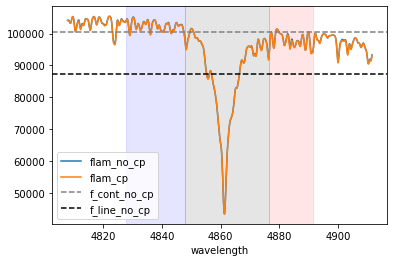

In [13]:
# Let's look at the hydrogen absorption line...
plot_absorption_line( \
    pick_spectrum( \
        data_set='m33_0.01', \
        heavy_metal_c=790, \
        age_mil=11 \
    ), \
    'H_beta' \
)